# Guard Cell Abscinic Acid

<h1 style="margin-bottom: 50px;"><b> BooLEVARD Tutorials</b></h1>
<h5 style="margin-bottom: 2px; margin-top: 0px;">
    <b><span style="color: green;">[Tutorial 2]</span> <span>Guard Cell Abscinic Acid</b></span>
</h5>
<p>

In this tutorial, we will use a Boolean model representing the signaling events taking place upon **ABA-induced stomatal closure** in plant guard cells. Stomata are microscopic pores on the leaf surface thatregulate gas exchange, and their aperture is tightly controlled by a pair of guard cells. In response to drought, the hormone abscisic acid (ABA) promotes stomatal closure to minimize water loss. This complex physiological response involves a broad aarray of molecular components, including ion channels, secondary messengers, and cytoskeletal regulators. The model integrates more than 40 experimetally characterized components into a unified **signal transduction network** that captures the main regulatory interactions driving guard cell shrinkage and stomatal closure. It successfully reproduces known physiological and pathway-level respones to ABA.

</p>
<p style="font-size:90%; color:gray;">
Li S, Assmann SM, Albert R (2006).  
<i>Predicting Essential Components of Signal Transduction Networks: A Dynamic Model of Guard Cell Abscisic Acid Signaling.</i>  
PLOS Biology 4(10): e312.  
<a href="https://doi.org/10.1371/journal.pbio.0040312" target="_blank">https://doi.org/10.1371/journal.pbio.0040312</a>
</p>


In [67]:
import biolqm
import tempfile
import re
import boolevard as blv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PyComplexHeatmap import * 
from libsbml import *
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, leaves_list

The **Guard Cell Abscisic Acid Signaling** Boolean Model is stored in [Cell Collective](https://research.cellcollective.org/dashboard#module/2161:1/guard-cell-abscisic-acid-signaling/1). Boolean models can be downloaded in SBML format from Cell Collective, but BooLEVARD uses Boolean models in BoolNet format as input. Accordingly, we must define a small function to convert SBML to BoolNet models:

In [ ]:
# Convert SBML-qual model to bnet format
def sbml2bnet(sbml_file, bnet_file):
    reader = SBMLReader()
    document = reader.readSBMLFromFile(sbml_file)
    model = document.getModel()
    qual = model.getPlugin("qual")
    id2name = {}
    for i in range(qual.getNumQualitativeSpecies()):
        qs = qual.getQualitativeSpecies(i)
        id2name[qs.getId()] = qs.getName() if qs.isSetName() else qs.getId()
    equations = {}
    new_lines = []
    for transition in qual.getListOfTransitions():
        outputs = transition.getListOfOutputs()
        target_id = outputs[0].getQualitativeSpecies()
        target_name = id2name.get(target_id, target_id)
        function_terms = transition.getListOfFunctionTerms()
        formula = formulaToL3String(function_terms[0].getMath())
        normal_formula = re.sub(r'\|\|', '|', formula)  # convert || to |
        normal_formula = re.sub(r'&&', '&', normal_formula)  # convert && to &
        normal_formula = re.sub(r'\b(\w+)\s*==\s*1\b', r'\1', normal_formula)  # convert <var> == 1 to <var>
        normal_formula = re.sub(r'\b(\w+)\s*==\s*0\b', r'~\1', normal_formula)
        normal_formula = normal_formula.replace('!', '~')
        for node_id, node_name in id2name.items():
                normal_formula = re.sub(rf'\b{re.escape(node_id)}\b', node_name, normal_formula)
        equations[target_name] = normal_formula
    for var, formula in equations.items():
        new_lines.append(f"{var}, {formula}\n")
    inputs = [node for node in list(id2name.values()) if node not in list(equations.keys())]
    for input in inputs:
        new_lines.append(f"{input}, {input}\n")  
    with open(bnet_file, "w") as out:
            out.writelines(new_lines)
    print(f"✅ SBML-qual model successfully converted to bnet: {bnet_file}")      

Now, we can generate the BoolNet version of the model:

In [68]:
# The SBML model is stored in:
model_sbml_path = "resources/Guard Cell Abscisic Acid Signaling (SBML).sbml"
# We will save the BoolNet model in:
model_bnet_path = "resources/Guard Cell Abscisic Acid Signaling.bnet"

# Convert SBML to BoolNet format
sbml2bnet(model_sbml_path, model_bnet_path)

✅ SBML-qual model successfully converted to bnet: resources/Guard Cell Abscisic Acid Signaling.bnet


Let's now load it with BooLEVARD, and retrieve some basic information:

In [85]:
# Load te BoolNet model with BooLEVARD
model = blv.Load(model_bnet_path)
print(f"Number of nodes: {len(model.Nodes)}")
print(f"Number of inputs: {len(model.Info.index[model.Info.index == model.Info['DNF'].apply(str)])}, ({', '.join(list((model.Info.index[model.Info.index == model.Info['DNF'].apply(str)])))})")
print(f"Number of stable states: {len(model.Info.columns)-2}")

Number of nodes: 44
Number of inputs: 4, (ABA, ABH1, GCR1, ERA1)
Number of stable states: 16


In [86]:
model.Info

,11,9,10,8,7,6,5,4,1,0,2,3,13,15,12,14,DNF,NDNF
cGMP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GC,~GC
RCN1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,ABA,~ABA
AGB1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,GPA1,~GPA1
Actin,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"Or(Ca2_c, And(~Ca2_c, ~RAC1))","And(~Ca2_c, RAC1)"
cADPR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ADPRc,~ADPRc
Depolar,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"Or(AnionEM, Ca2_c, KEV, And(~AnionEM, ~Ca2_c, ...","And(~AnionEM, ~Ca2_c, HTPase, ~KEV, KOUT)"
KEV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ca2_c,~Ca2_c
KAP,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"Or(And(~Ca2_c, Depolar), And(Depolar, ~pH))","Or(~Depolar, And(Ca2_c, pH))"
Closure,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,"Or(And(Actin, AnionEM, KAP, ~Malate), And(Acti...","Or(~Actin, ~AnionEM, Malate, And(~KAP, ~KOUT))"
NIA12,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,RCN1,~RCN1


We observe that the model has 44 nodes, four of them being inputs (*ABA*, *ABH1*, *GCR1*, *ERA1*) and it reaches 16 stable states. Let's use BooLEVARD to count the paths toward every node across the 16 stable states. 

In [87]:
# Count paths
paths = model.CountPaths(model.Nodes, ss_wise = True)

Evaluating Stable State: 11
cGMP: -4, 2.5828679402669272e-06 minutes.
RCN1: 1, 2.0265579223632812e-07 minutes.
AGB1: 0, 2.7815500895182292e-08 minutes.
Actin: 6, 1.6689300537109375e-06 minutes.
cADPR: -4, 5.920728047688802e-07 minutes.
Depolar: 4, 4.212061564127604e-07 minutes.
KEV: -4, 5.364418029785156e-07 minutes.
KAP: 8, 8.861223856608073e-07 minutes.
Closure: -4, 4.967053731282552e-07 minutes.
NIA12: 1, 1.8676122029622396e-07 minutes.
CaIM: -4, 5.364418029785156e-07 minutes.
PLD: 0, 1.986821492513021e-07 minutes.
AnionEM: -4, 3.0597050984700523e-07 minutes.
ROP10: -1, 3.417332967122396e-07 minutes.
NO: -4, 4.490216573079427e-07 minutes.
S1P: 1, 1.7881393432617188e-07 minutes.
GPA1: 0, 3.178914388020833e-08 minutes.
ROP2: 0, 1.8278757731119793e-07 minutes.
InsP3: -4, 4.3710072835286457e-07 minutes.
SphK: 1, 1.708666483561198e-07 minutes.
NOS: -4, 4.172325134277344e-07 minutes.
Atrboh: -1, 9.139378865559896e-08 minutes.
Ca2_ATPase: -4, 4.212061564127604e-07 minutes.
OST1: 1, 1.78813

Let's now compare BooLEVARD's output with stable-state analysis results:

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Estimated legend width: 7.5 mm


Text(0.013, 1.0025, '   ________')

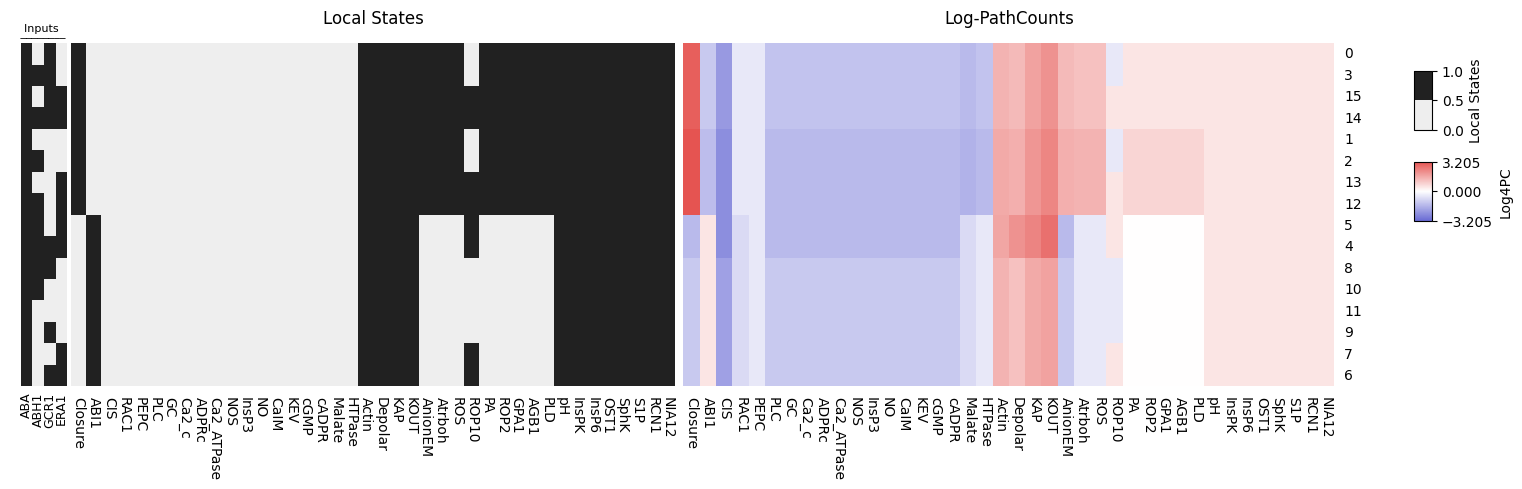

In [90]:
# Convert CountPaths output to a DataFrame
paths_sum = pd.DataFrame(paths)
paths_sum.columns = model.Nodes 
paths_sum = paths_sum.loc[:, ~paths_sum.columns.isin(["ABA", "ABH1", "GCR1", "ERA1"])] # Filter out the input nodes
paths_sum.index = model.Info.columns[:-2] # Set the index to the stable states

# Log-transform the data for better visualization
def log_signed(x, base):
        return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)
paths_sum = log_signed(paths_sum, 4) # Let's do the signed log-transform with base 4

# Extract the stable states from te model.Info object
ls_info = model.Info.loc[model.Nodes, model.Info.columns[:-2]].transpose()
ls_info = ls_info.loc[:, ~ls_info.columns.isin(["ABA", "ABH1", "GCR1", "ERA1"])]
ls_info.index = paths_sum.index

# Prepare for plotting
# - Annotations
annot_ls = pd.DataFrame(["Local State"]*len(ls_info.columns), columns = ["Score"])
annot_paths = pd.DataFrame(["Path Count"]*len(ls_info.columns), columns = ["Score"])
annot_ls.index = annot_paths.index = paths_sum.columns
annot_inputs = model.Info.loc[["ABA", "ABH1", "GCR1", "ERA1"], model.Info.columns[:-2]].transpose().astype(str)
annot_inputs.index = paths_sum.index
colors_row_ha = {input_name: {"0": "#eeeeee", "1": "#212121"} for input_name in ["ABA", "ABH1", "GCR1", "ERA1"]}
row_ha_inputs = HeatmapAnnotation(df = annot_inputs, colors = colors_row_ha, plot = False, legend = False, axis = 0, label_kws = dict(size = 9), label_side = "bottom", wgap = 0.001, plot_kws = dict(linewidth = 0.001, linecolor = "white", linestyle = ":"), legend_width=90) # Annotation for inputs

# Perform row (nodes) and column (stablee states) clustering
row_linkage = linkage(paths_sum.values, method="average", metric="euclidean")
col_linkage = linkage(paths_sum.values.T, method="average", metric="euclidean")
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)
row_labels = paths_sum.index[row_order]
col_labels = paths_sum.columns[col_order]
paths_sum = paths_sum.loc[row_labels, col_labels]
ls_info = ls_info.loc[row_labels, col_labels]

# - Subheatmap 1: Local States
cmap_ls = ListedColormap(["#eeeeee", "#212121"])
hmap_ls = ClusterMapPlotter(
    ls_info.astype(int),
    row_cluster = False, col_cluster = False,
    show_rownames = True, show_colnames = True,
    cmap = cmap_ls, linewidths = 0.001, linecolor = "white",
    plot = False,
    plot_legend = True, label = "Local States",
    left_annotation = row_ha_inputs,
    xlabel = "Local States",
    xlabel_kws=dict(color='black',fontsize=12,labelpad=7, x = 1, ha = "center"),
    xlabel_side='top'
)

# - Subheatmap 2: Path Count
cmap_paths = LinearSegmentedColormap.from_list("custom_diverging", ["#696bd4", "#FFFFFF", "#e55451"], N = 256)
vmax_paths = np.max(np.abs(paths_sum.values))
hmap_paths = ClusterMapPlotter(
    paths_sum,
    row_cluster = False, col_cluster = False,
    show_rownames = True, show_colnames = True,
    cmap = cmap_paths, vmin = -vmax_paths, vmax = vmax_paths,
    linewidths = 0.001, linecolor = "white",
    plot = False,
    plot_legend = True, label = "Log4PC",
    xlabel = "Log-PathCounts",
    xlabel_kws=dict(color='black',fontsize=12,labelpad=7),
    xlabel_side='top'
)

# - Merge subheatmaps
hmap_list = [hmap_ls, hmap_paths]
plt.figure(figsize = (17, 4))
ax, legend_axes = composite(cmlist = hmap_list, main = 0, col_gap = 0.1, legend_hpad = 50, legend_gap = 8)

ax.text(0.013, 1.015, "  Inputs", ha = "center", va = "bottom", fontsize = 8)
ax.text(0.013, 1.0025, "   ________", ha = "center", va = "bottom", fontsize = 8)

<div style="font-size:90%;">

**Figure 1.** Heatmaps showing the Boolean states (left) and the corresponding transduction path counts (right), calculated using BooLEVARD, for the stable states reached by the Guard Cell Ascibic Acid Boolean model. The Boolean activation states of the input nodes (*ABA*, *ABH1*, *GCR1* and *ERA1*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

We observe that for some stable states driven by nearly identical input combinations (e.g., similar patterns in *ABA*, *ABH1*, *GCR1*, and *ERA1*), the activating and inhibitory path counts for certain nodes vary considerably. This reveals that although the network reaches the same binary ON/OFF state, the intensity and number of signaling paths regulating a node can differ significantly.

**Calcium signaling modulates stomatal closure inhibition**

***Key proteins and their role in calcium signaling in guard cells:***

- **ABA:** A phytohormone that promotes cytosolic calcium influx in guard cells by activating plasma membrane calcium channels and releasing calcium from intracellular stores.
- **ABH1:** A regulator involved in ABA signaling that modulates calcium sensitivity, helping control stomatal closure during stress. *abh1* mutants are hypersensitive to ABA.
- **ERA1:** Required for proper stomatal opening in response to blue light and for maintaining overall stomatal openness.
- **CaIM:** A calcium channel that facilitates calcium influx into the cytosol, favoring stomatal closure.

The stable states associated with *Closure* inhibition (see **Figure 1**) can be divided into two groups based on the intensity of inhibiti:
- **Higher Closure Inhibition (HiC):** stable states 4 and 5.
- **Lower Closure Inhibition (LoC):** stable states 7, 8, 9, 10 and 11.

These stable states share identical ON/OFF patterns for most nodes. The only notable difference within the LoC group is that *ROP10* is OFF in states 8, 9, 10, and 11, while it is ON in states 6 and 7. Despite this, the intensity of *Closure* inhibition remains similar across all LoC states.

***Differences between HiC and LoC groups***

The main differences between the High Closure Inhibition (HiC) and Lower Closure Inhibition (LoC) groups arise from the simultaneous activation of two input nodes in HiC: *ABH1* and *ERA1*. This joint activation regulates cytosolic calcium levels by inactivating the *CaIM* channel, a mechanism absent in the LoC group. *CaIM* inactivation leads to lower calcium influx, which impairs anion effluxing, and blocks stomatal closure.

An alternative way to inactivate *CaIM* is through membrane depolarization (*Depolar* node active), which occurs in both groups but is stronger in HiC. This depolarization partly depends on increased potassium efflux seen in HiC. Since *CaIM* is inactive, NOS is not activated, reducing NO production, a key inhibitor of potassium efflux. As a result, potassium efflux increases, promoting depolarization. In summary: since this depolarization depends on potassium efflux, which is regulated by NOS/NO production, itself controlled by calcium influx via *CaIM*, and *CaIM* is inhibited by *ABH1* and *ERA1* in HiC, this pathway further amplifies the inhibition of stomatal closure in the HiC group.

***Overview of the inhibitory pathway in HiC:***

1.- *ABH1* and *ERA1* inhibit *CaIM*; this axis is missing in the LoC group.  
2.- *CaIM* inhibition blocks calcium influx.  
3.- Reduced calcium influx inhibits anion efflux.  
4.- Reduced anion efflux inhibits stomatal closure.  
5.- Reduced calcium influx fails to activate NOS/NO production.  
6.- Blockage of NOS/NO production allows potassium efflux.  
7.- Potassium efflux enhances membrane depolarization.  
8.- Membrane depolarization further inhibits *CaIM*. 

